# Currency Predictor PT2
Continuation of https://github.com/chaseabrown/Jupyter-Notebooks/blob/main/Currency%20Predictor.ipynb

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
import sklearn
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
import datetime
import xgboost
from xgboost import XGBRegressor, DMatrix
from statsmodels.tsa.seasonal import seasonal_decompose

## Methods

In [2]:
def addFeatures(dataset, currencyName):
    featureData = pd.DataFrame()

    #Add Original Features
    featureData[currencyName + '_Price'] = dataset['Price']
    featureData[currencyName + '_Open'] = dataset['Open']

    #Add Day Before Features
    featureData[currencyName + '_Price_DB'] = dataset['Price'].shift(1)
    featureData[currencyName + '_Open_DB'] = dataset['Open'].shift(1)
    featureData[currencyName + '_High_DB'] = dataset['High'].shift(1)
    featureData[currencyName + '_Low_DB'] = dataset['Low'].shift(1)

    #Add Price Average Windows
    featureData[currencyName + '_Price_Average_Week'] = dataset['Price'].rolling(window=5).mean().shift(1)
    featureData[currencyName + '_Price_Average_Month'] = dataset['Price'].rolling(window=21).mean().shift(1)
    featureData[currencyName + '_Price_Average_3Month'] = dataset['Price'].rolling(window=63).mean().shift(1)
    featureData[currencyName + '_Price_Average_Year'] = dataset['Price'].rolling(window=252).mean().shift(1)

    #Add Price Average Ratios
    featureData[currencyName + '_Price_AVGRatio_Week_Month'] = featureData[currencyName + '_Price_Average_Week']/featureData[currencyName + '_Price_Average_Month']
    featureData[currencyName + '_Price_AVGRatio_Week_3Month'] = featureData[currencyName + '_Price_Average_Week']/featureData[currencyName + '_Price_Average_3Month']
    featureData[currencyName + '_Price_AVGRatio_Week_Year'] = featureData[currencyName + '_Price_Average_Week']/featureData[currencyName + '_Price_Average_Year']
    featureData[currencyName + '_Price_AVGRatio_Month_3Month'] = featureData[currencyName + '_Price_Average_Month']/featureData[currencyName + '_Price_Average_3Month']
    featureData[currencyName + '_Price_AVGRatio_Month_Year'] = featureData[currencyName + '_Price_Average_Month']/featureData[currencyName + '_Price_Average_Year']
    featureData[currencyName + '_Price_AVGRatio_3Month_Year'] = featureData[currencyName + '_Price_Average_3Month']/featureData[currencyName + '_Price_Average_Year']

    #Add Price Standard Deviations
    featureData[currencyName + '_Price_STD_Week'] = dataset['Price'].rolling(window=5).std().shift(1)
    featureData[currencyName + '_Price_STD_Month'] = dataset['Price'].rolling(window=21).std().shift(1)
    featureData[currencyName + '_Price_STD_3Month'] = dataset['Price'].rolling(window=63).std().shift(1)
    featureData[currencyName + '_Price_STD_Year'] = dataset['Price'].rolling(window=252).std().shift(1)

    #Add Price Standard Deviations Ratios
    featureData[currencyName + '_Price_STDRatio_Week_Month'] = featureData[currencyName + '_Price_STD_Week']/featureData[currencyName + '_Price_STD_Month']
    featureData[currencyName + '_Price_STDRatio_Week_3Month'] = featureData[currencyName + '_Price_STD_Week']/featureData[currencyName + '_Price_STD_3Month']
    featureData[currencyName + '_Price_STDRatio_Week_Year'] = featureData[currencyName + '_Price_STD_Week']/featureData[currencyName + '_Price_STD_Year']
    featureData[currencyName + '_Price_STDRatio_Month_3Month'] = featureData[currencyName + '_Price_STD_Month']/featureData[currencyName + '_Price_STD_3Month']
    featureData[currencyName + '_Price_STDRatio_Month_Year'] = featureData[currencyName + '_Price_STD_Month']/featureData[currencyName + '_Price_STD_Year']
    featureData[currencyName + '_Price_STDRatio_3Month_Year'] = featureData[currencyName + '_Price_STD_3Month']/featureData[currencyName + '_Price_STD_Year']

    #Add Daily, Weekly, Monthly, Quarterly, and Yearly Returns
    featureData[currencyName + '_Day_Return'] = ((dataset['Price']-dataset['Price'].shift(1))/dataset['Price'].shift(1)).shift(1)
    featureData[currencyName + '_Week_Return'] = ((dataset['Price']-dataset['Price'].shift(5))/dataset['Price'].shift(5)).shift(1)
    featureData[currencyName + '_Month_Return'] = ((dataset['Price']-dataset['Price'].shift(21))/dataset['Price'].shift(21)).shift(1)
    featureData[currencyName + '_Quarter_Return'] = ((dataset['Price']-dataset['Price'].shift(63))/dataset['Price'].shift(63)).shift(1)
    featureData[currencyName + '_Year_Return'] = ((dataset['Price']-dataset['Price'].shift(252))/dataset['Price'].shift(252)).shift(1)

    #Add Average of Daily Return
    featureData[currencyName + '_Day_Return_Week_AVG'] = featureData[currencyName + '_Day_Return'].rolling(window=5).mean()
    featureData[currencyName + '_Day_Return_Month_AVG'] = featureData[currencyName + '_Day_Return'].rolling(window=21).mean()
    featureData[currencyName + '_Day_Return_3Month_AVG'] = featureData[currencyName + '_Day_Return'].rolling(window=63).mean()
    featureData[currencyName + '_Day_Return_Year_AVG'] = featureData[currencyName + '_Day_Return'].rolling(window=252).mean()

    featureData = featureData.dropna(axis=0)
    return featureData

In [3]:
def readData(filename):
    dataset = pd.read_csv(filename)
    dataset['Date'] = pd.to_datetime(dataset['Date'])
    dataset = dataset.set_index('Date')
    dataset = dataset.sort_index()
    dataset['Change %'] = dataset["Change %"].str.replace(r"[^0-9.-]",'').astype(float)
    dataset['Change %'] = dataset["Change %"]/100
    return dataset

In [4]:
def baggingRegression(xTrain, yTrain):
    lin = LinearRegression()
    model = BaggingRegressor(base_estimator=lin, n_estimators=100, oob_score=True, n_jobs=-1)
    model.fit(xTrain, yTrain)
    
    return model

In [5]:
def testModel(model, xTest, yTest, name, openingPrices):
    
    predictions = model.predict(xTest)
    
    print('OOB: {0:.3f}'.format(model.oob_score))
    print('RMSE: {0:.3f}'.format(mean_squared_error(yTest, predictions)**0.5))
    print('MAE: {0:.3f}'.format(mean_absolute_error(yTest, predictions)))
    print('R^2: {0:.3f}'.format(r2_score(yTest, predictions)))
    
    dates = yTest.index.values
    datestest = testData.index.values


    truePositive = {'prices': [], 'dates': [], 'cash':[], 'optimalCash':[]}
    falsePositive = {'prices': [], 'dates': [], 'cash':[], 'optimalCash':[]}
    trueNegatives = {'prices': [], 'dates': [], 'cash':[], 'optimalCash':[]}
    falseNegatives = {'prices': [], 'dates': [], 'cash':[], 'optimalCash':[]}
    cash = 100
    optimalCash = 100
    cashLog = []
    optimalCashLog = []
    for i in range(0, len(dates)):
        if (predictions[i] > openingPrices[i]):
            if yTest[i] > openingPrices[i]:
                truePositive['prices'].append(openingPrices[i])
                truePositive['dates'].append(dates[i])
                truePositive['cash'].append(cash)
                truePositive['optimalCash'].append(optimalCash)
                cash += cash*(((yTest[i]-openingPrices[i])/openingPrices[i]))
                optimalCash += optimalCash*(((yTest[i]-openingPrices[i])/openingPrices[i]))
                
            else:
                falsePositive['prices'].append(openingPrices[i])
                falsePositive['dates'].append(dates[i])
                falsePositive['cash'].append(cash)
                falsePositive['optimalCash'].append(optimalCash)
                cash += cash*(((yTest[i]-openingPrices[i])/openingPrices[i]))
        else:
            if yTest[i] > openingPrices[i]:
                falseNegatives['prices'].append(openingPrices[i])
                falseNegatives['dates'].append(dates[i])
                falseNegatives['cash'].append(cash)
                falseNegatives['optimalCash'].append(optimalCash)
                optimalCash += optimalCash*(((yTest[i]-openingPrices[i])/openingPrices[i]))
            else:
                trueNegatives['prices'].append(openingPrices[i])
                trueNegatives['dates'].append(dates[i])
                trueNegatives['cash'].append(cash)
                trueNegatives['optimalCash'].append(optimalCash)
        cashLog.append(cash)
        optimalCashLog.append(optimalCash)

    plt.figure(figsize = (18,9))
    plot_truth, = plt.plot(dates, yTest)
    plot_pred, = plt.plot(dates, predictions)
    #plt.vlines(testStartDate, min(openingPrices), max(openingPrices), linestyles='--', colors='gray', label='Train/Test data cut-off')
    plt.legend([plot_truth, plot_pred], ['Truth', 'Prediction'])
    plt.title(name + ' Closing Price : Prediction vs Truth - BGR')
    plt.show()
    
    plt.figure(figsize = (18,9))
    plot_cash = plt.plot(dates, cashLog)
    plot_cash = plt.plot(dates, cashLog, color = "grey")
    plot_fp = plt.scatter(falsePositive['dates'], falsePositive['cash'], color = "red")
    plot_fn = plt.scatter(falseNegatives['dates'], falseNegatives['cash'], color = "green")
    #plt.vlines(testStartDate, min(cashLog), max(cashLog), linestyles='--', colors='gray', label='Train/Test data cut-off')
    plt.legend([plot_cash, plot_fp, plot_fn, plot_cash], ['Cash', 'False Positive', 'False Negative'])
    plt.title('Cashflow if only trading ' + name)
    plt.show()

    plt.figure(figsize = (18,9))
    plot_cash = plt.plot(dates, optimalCashLog)
    plot_cash = plt.plot(dates, optimalCashLog, color = "grey")
    plot_fp = plt.scatter(falsePositive['dates'], falsePositive['optimalCash'], color = "red")
    plot_fn = plt.scatter(falseNegatives['dates'], falseNegatives['optimalCash'], color = "green")
    #plt.vlines(testStartDate, min(optimalCashLog), max(optimalCashLog), linestyles='--', colors='gray', label='Train/Test data cut-off')
    plt.legend([plot_cash, plot_fp, plot_fn, plot_cash], ['Cash', 'False Positive', 'False Negative'])
    plt.title('Optimal Cashflow if only trading ' + name)
    plt.show()
    
    print(pd.DataFrame(cashLog).describe())

## Data Prep

In [6]:
#Read in Historical Data
datasetJPY = readData('USD_JPY Historical Data.csv')
datasetEUR = readData('USD_EUR Historical Data.csv')
datasetGBP = readData('USD_GBP Historical Data.csv')
datasetCAD = readData('USD_CAD Historical Data.csv')

#Adding Features and combining Dataset
allCurrenciesData = addFeatures(datasetJPY, "JPY")
allCurrenciesData = allCurrenciesData.join(addFeatures(datasetEUR, "EUR"))
allCurrenciesData = allCurrenciesData.join(addFeatures(datasetGBP, "GBP"))
allCurrenciesData = allCurrenciesData.join(addFeatures(datasetCAD, "CAD"))
allCurrenciesData.head()

<ipython-input-3-95f291863fa8>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset['Change %'] = dataset["Change %"].str.replace(r"[^0-9.-]",'').astype(float)


,JPY_Price,JPY_Open,JPY_Price_DB,JPY_Open_DB,JPY_High_DB,JPY_Low_DB,JPY_Price_Average_Week,JPY_Price_Average_Month,JPY_Price_Average_3Month,JPY_Price_Average_Year,...,CAD_Price_STDRatio_3Month_Year,CAD_Day_Return,CAD_Week_Return,CAD_Month_Return,CAD_Quarter_Return,CAD_Year_Return,CAD_Day_Return_Week_AVG,CAD_Day_Return_Month_AVG,CAD_Day_Return_3Month_AVG,CAD_Day_Return_Year_AVG
Date,,,,,,,,,,,,,,,,,,,,,
2004-01-07,106.23,106.17,106.21,106.26,106.43,106.03,106.876,107.366667,108.476190,115.572817,...,0.183350,0.004295,-0.005721,-0.009398,-0.039582,-0.162542,-0.001128,-0.000429,-0.000623,-0.000688
2004-01-08,106.19,106.15,106.23,106.17,106.45,105.88,106.648,107.331429,108.437619,115.526111,...,0.187834,0.001711,-0.006708,-0.014233,-0.024830,-0.160836,-0.001327,-0.000663,-0.000382,-0.000680
2004-01-09,106.61,106.13,106.19,106.15,106.26,106.08,106.392,107.232857,108.394444,115.478651,...,0.196077,-0.006909,-0.003117,-0.022017,-0.030613,-0.165329,-0.000612,-0.001040,-0.000476,-0.000701
2004-01-12,106.71,106.64,106.61,106.13,108.27,106.11,106.302,107.163810,108.358095,115.432103,...,0.207235,-0.006566,-0.013736,-0.035150,-0.040323,-0.169835,-0.002751,-0.001683,-0.000636,-0.000722
2004-01-13,106.23,106.64,106.71,106.64,106.77,106.35,106.390,107.114286,108.313333,115.387024,...,0.213491,0.004013,-0.003514,-0.030616,-0.039012,-0.163224,-0.000691,-0.001460,-0.000614,-0.000691


In [7]:
#Split Testing and Training Data
start = datetime.datetime(2004, 1, 1,0,0)
end = datetime.datetime(2018, 12, 31, 0, 0)
trainData = allCurrenciesData.loc[start:end]
trainData.describe()

,JPY_Price,JPY_Open,JPY_Price_DB,JPY_Open_DB,JPY_High_DB,JPY_Low_DB,JPY_Price_Average_Week,JPY_Price_Average_Month,JPY_Price_Average_3Month,JPY_Price_Average_Year,...,CAD_Price_STDRatio_3Month_Year,CAD_Day_Return,CAD_Week_Return,CAD_Month_Return,CAD_Quarter_Return,CAD_Year_Return,CAD_Day_Return_Week_AVG,CAD_Day_Return_Month_AVG,CAD_Day_Return_3Month_AVG,CAD_Day_Return_Year_AVG
count,3909.000000,3909.000000,3909.000000,3909.000000,3909.000000,3909.000000,3909.000000,3909.000000,3909.000000,3909.000000,...,3909.000000,3909.000000,3909.000000,3909.000000,3909.000000,3909.000000,3909.000000,3909.000000,3909.000000,3.909000e+03
mean,103.504919,103.489990,103.504057,103.488920,103.959483,102.990200,103.502085,103.492580,103.467933,103.566171,...,0.526817,0.000034,0.000156,0.000467,0.001123,-0.000368,0.000031,0.000024,0.000020,8.162672e-08
std,13.216641,13.208551,13.216355,13.208158,13.249516,13.174586,13.202888,13.158803,13.043041,12.599933,...,0.236184,0.005903,0.013149,0.025905,0.045006,0.091583,0.002627,0.001223,0.000711,3.575190e-04
min,75.820000,75.760000,75.820000,75.760000,76.000000,75.580000,76.060000,76.630000,76.852063,78.568135,...,0.152427,-0.036955,-0.095219,-0.086516,-0.160887,-0.209844,-0.019692,-0.004260,-0.002742,-8.793052e-04
25%,93.740000,93.740000,93.740000,93.740000,94.380000,93.220000,93.832000,94.122381,93.727143,93.695079,...,0.360337,-0.003332,-0.007740,-0.015317,-0.025943,-0.061375,-0.001543,-0.000721,-0.000405,-2.382166e-04
50%,106.670000,106.630000,106.670000,106.620000,107.060000,106.080000,106.646000,106.755714,107.076667,108.233532,...,0.472098,0.000000,-0.000200,-0.000396,0.001698,-0.014257,-0.000031,-0.000007,0.000039,-4.367321e-05
75%,113.440000,113.430000,113.440000,113.430000,113.910000,112.920000,113.402000,113.099524,112.938254,112.483690,...,0.672588,0.003213,0.007697,0.015379,0.025752,0.048811,0.001552,0.000739,0.000420,2.027218e-04
max,125.620000,125.580000,125.620000,125.580000,125.860000,124.520000,124.724000,124.200476,123.704286,121.151032,...,1.539959,0.033449,0.089061,0.254063,0.267182,0.387052,0.017306,0.010931,0.003823,1.332075e-03


In [8]:
start = datetime.datetime(2019, 1, 1,0,0)
end = datetime.datetime(2021, 12, 13, 0, 0)
testData = allCurrenciesData.loc[start:end]
testData.describe()

,JPY_Price,JPY_Open,JPY_Price_DB,JPY_Open_DB,JPY_High_DB,JPY_Low_DB,JPY_Price_Average_Week,JPY_Price_Average_Month,JPY_Price_Average_3Month,JPY_Price_Average_Year,...,CAD_Price_STDRatio_3Month_Year,CAD_Day_Return,CAD_Week_Return,CAD_Month_Return,CAD_Quarter_Return,CAD_Year_Return,CAD_Day_Return_Week_AVG,CAD_Day_Return_Month_AVG,CAD_Day_Return_3Month_AVG,CAD_Day_Return_Year_AVG
count,771.000000,771.000000,771.000000,771.000000,771.000000,771.000000,771.000000,771.000000,771.000000,771.000000,...,770.000000,770.000000,770.000000,770.000000,770.000000,770.000000,770.000000,770.000000,770.000000,770.000000
mean,108.438444,108.443528,108.433372,108.439546,108.751582,108.108703,108.426213,108.409492,108.393411,108.505396,...,0.586559,-0.000081,-0.000406,-0.001393,-0.003661,-0.010167,-0.000081,-0.000066,-0.000056,-0.000037
std,2.543090,2.536784,2.536895,2.531224,2.518617,2.543946,2.492839,2.371940,2.165890,1.669361,...,0.282870,0.004303,0.009355,0.018896,0.030330,0.049466,0.001870,0.000895,0.000479,0.000202
min,102.340000,102.380000,102.340000,102.380000,103.190000,101.180000,103.060000,103.460476,103.923810,105.888294,...,0.163694,-0.018604,-0.034045,-0.047311,-0.066713,-0.135415,-0.006858,-0.002291,-0.001071,-0.000569
25%,106.740000,106.770000,106.740000,106.770000,107.080000,106.370000,106.740000,107.085000,107.197302,107.124702,...,0.428477,-0.002423,-0.005884,-0.013473,-0.023188,-0.038556,-0.001176,-0.000638,-0.000366,-0.000146
50%,108.640000,108.670000,108.640000,108.670000,108.930000,108.390000,108.650000,108.748095,108.653810,108.259325,...,0.564809,-0.000082,-0.000582,-0.002684,-0.007463,-0.002261,-0.000110,-0.000121,-0.000110,-0.000002
75%,109.925000,109.900000,109.920000,109.900000,110.200000,109.685000,109.909000,109.874762,110.063413,109.980060,...,0.672315,0.002092,0.005115,0.008885,0.009180,0.026361,0.001024,0.000427,0.000154,0.000112
max,115.410000,115.420000,115.410000,115.420000,115.530000,115.240000,114.944000,114.117143,113.008254,111.330992,...,1.755614,0.021410,0.052773,0.097745,0.104010,0.094886,0.010391,0.004480,0.001585,0.000369


In [9]:
#Reformating for Models
trainData = trainData.dropna(axis=0)
testData = testData.dropna(axis=0)

X_train = trainData.drop(['JPY_Price', 'EUR_Price', 'GBP_Price', 'CAD_Price'], axis='columns')
y_train_JPY = trainData.JPY_Price
y_train_EUR = trainData.EUR_Price
y_train_GBP = trainData.GBP_Price
y_train_CAD = trainData.CAD_Price

X_test = testData.drop(['JPY_Price', 'EUR_Price', 'GBP_Price', 'CAD_Price'], axis='columns')
y_test_JPY = testData.JPY_Price
y_test_EUR = testData.EUR_Price
y_test_GBP = testData.GBP_Price
y_test_CAD = testData.CAD_Price


#Scaling the Data
#Fit Scalar using training
scaler = StandardScaler()
scaler.fit(X_train)

#Rescale both using the fit scaler
X_scaled_train = scaler.transform(X_train)
X_scaled_test = scaler.transform(X_test)

## Strategy 1
1. Use Bagging Regression to predict the closing prices of YEN, EUR, GBP, and CAD
2. If the predicted close is higher than the open then buy

- If more than 1 is a buy, split the bet equally

### JYP Training and Testing

OOB: 1.000
RMSE: 0.531
MAE: 0.363
R^2: 0.956


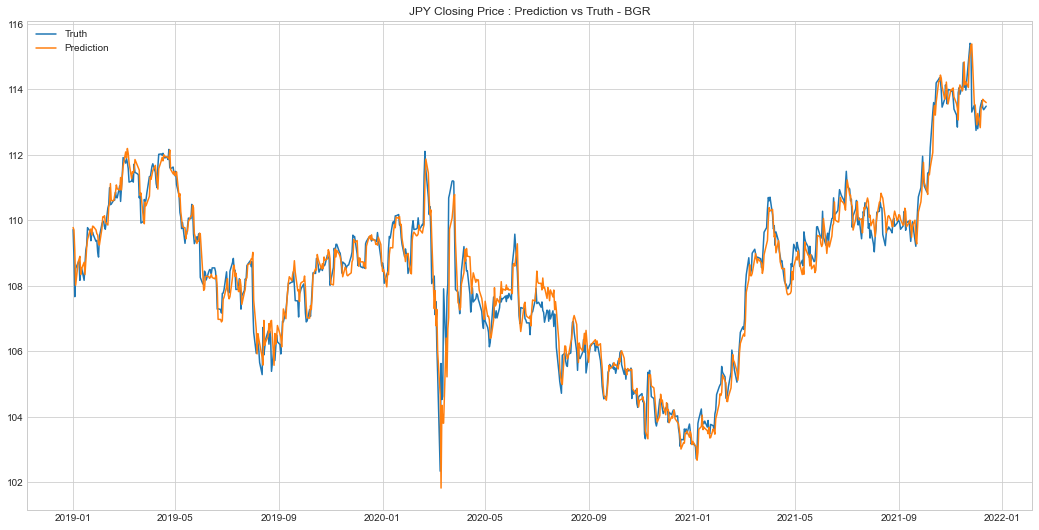

<ipython-input-5-2ce8cda70e39>:67: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fe4a9afee80>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend([plot_cash, plot_fp, plot_fn, plot_cash], ['Cash', 'False Positive', 'False Negative'])


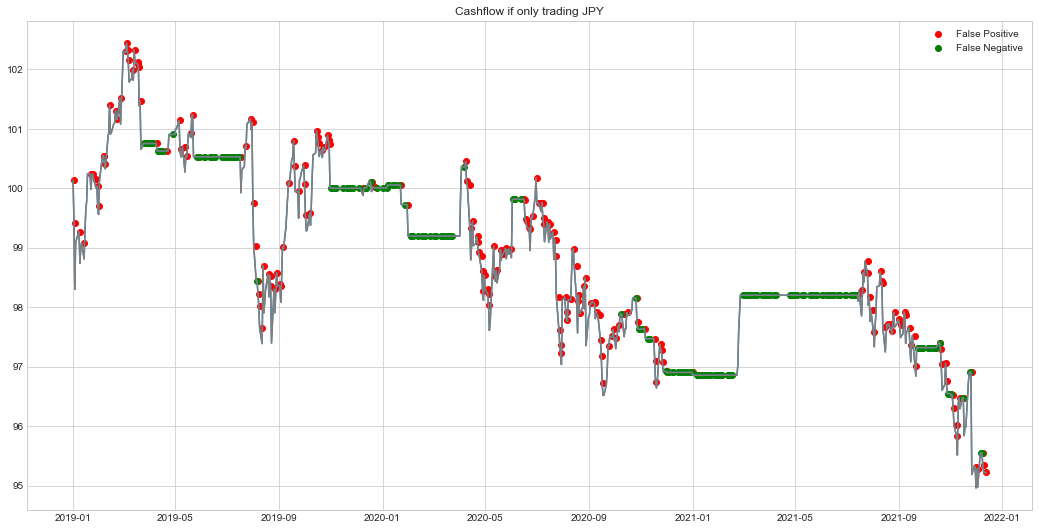

<ipython-input-5-2ce8cda70e39>:77: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fe4d1209550>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend([plot_cash, plot_fp, plot_fn, plot_cash], ['Cash', 'False Positive', 'False Negative'])


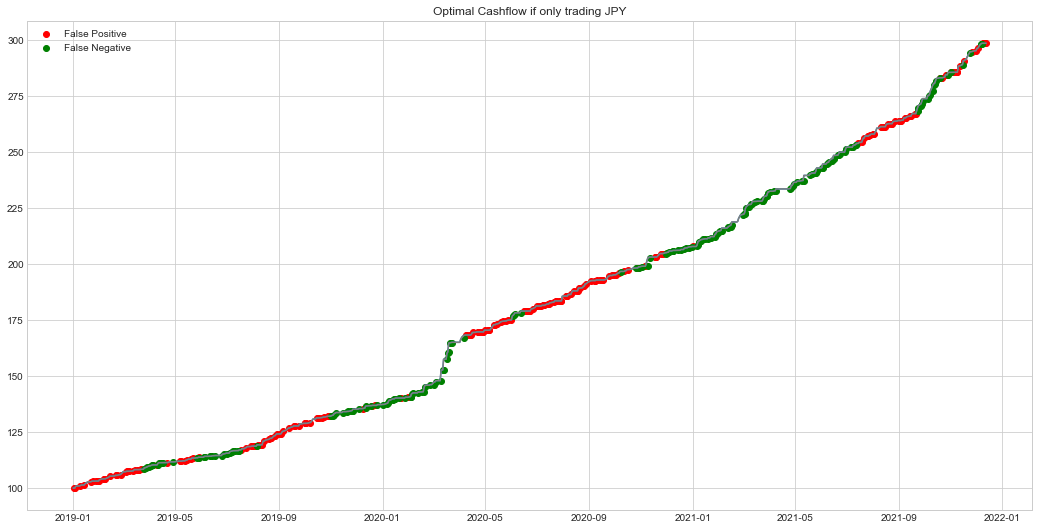

                0
count  770.000000
mean    98.787832
std      1.465606
min     94.958390
25%     97.675701
50%     98.527479
75%    100.009962
max    102.440462


In [10]:
modelJPY = baggingRegression(X_scaled_train, y_train_JPY)
testModel(modelJPY, X_scaled_test, y_test_JPY, "JPY", testData.JPY_Open)

### EUR Training and Testing

OOB: 1.000
RMSE: 0.004
MAE: 0.003
R^2: 0.986


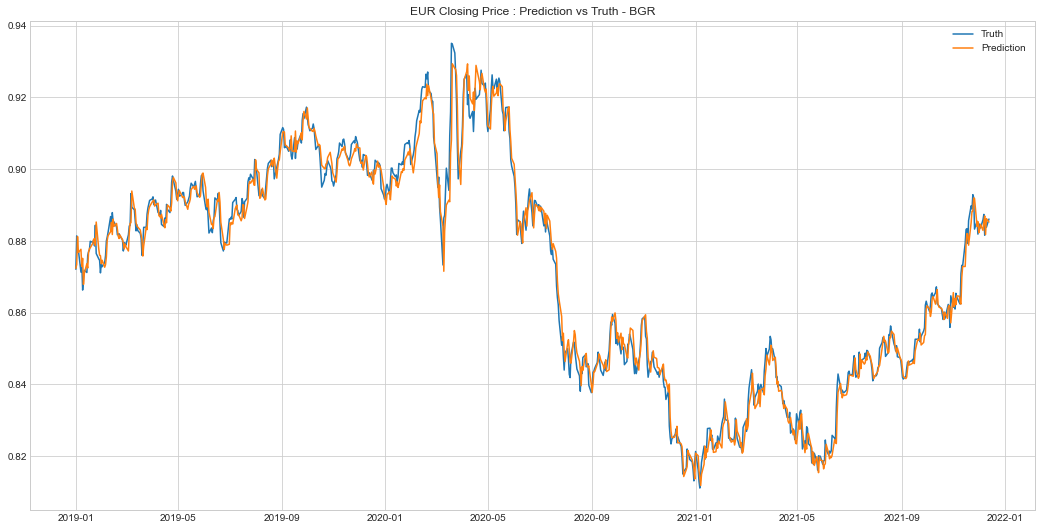

<ipython-input-5-2ce8cda70e39>:67: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fe4a9b78970>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend([plot_cash, plot_fp, plot_fn, plot_cash], ['Cash', 'False Positive', 'False Negative'])


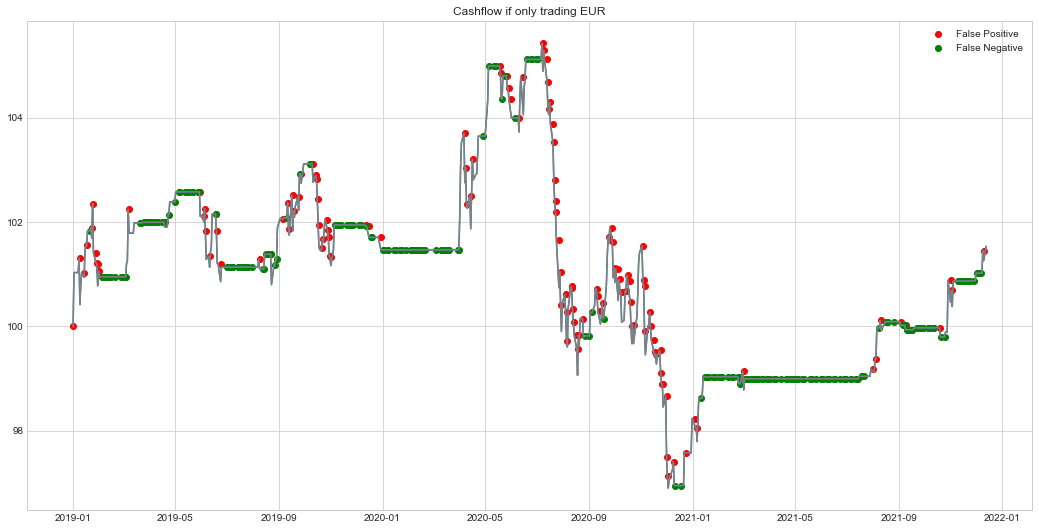

<ipython-input-5-2ce8cda70e39>:77: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fe4a9bf1a00>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend([plot_cash, plot_fp, plot_fn, plot_cash], ['Cash', 'False Positive', 'False Negative'])


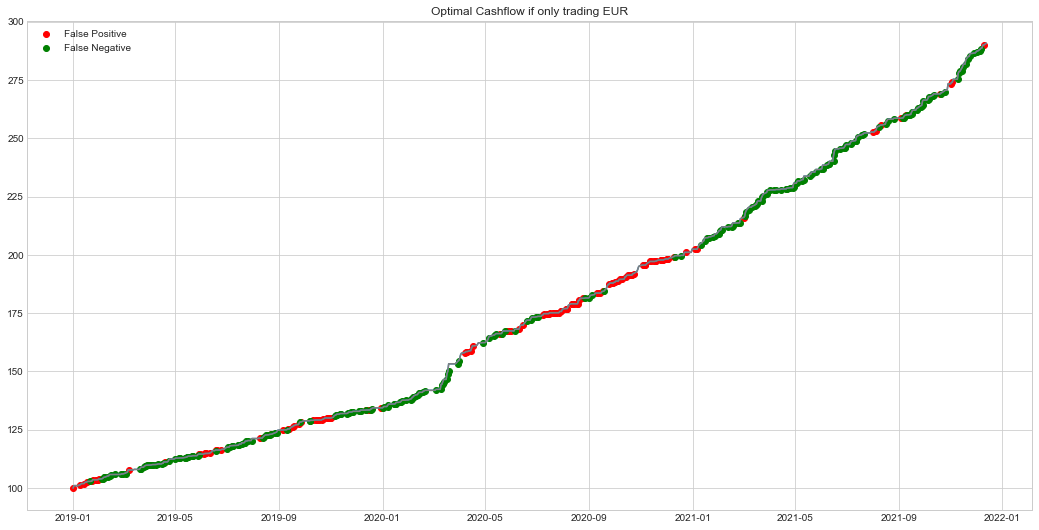

                0
count  770.000000
mean   100.934819
std      1.711068
min     96.901256
25%     99.614105
50%    101.101431
75%    101.943030
max    105.425244


In [11]:
modelEUR = baggingRegression(X_scaled_train, y_train_EUR)
testModel(modelEUR, X_scaled_test, y_test_EUR, "EUR", testData.EUR_Open)

### GBP Training and Testing

OOB: 1.000
RMSE: 0.004
MAE: 0.003
R^2: 0.982


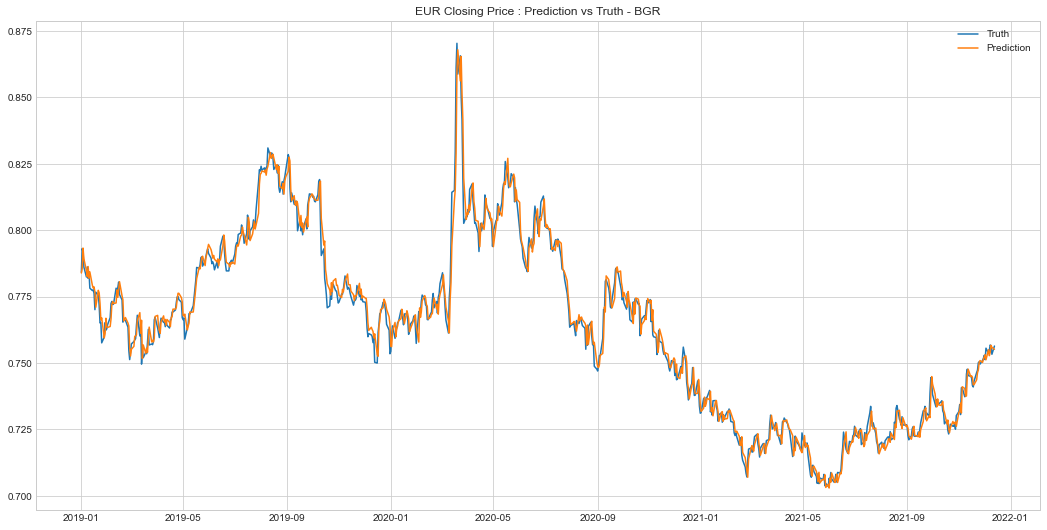

<ipython-input-5-2ce8cda70e39>:67: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fe4a0ee71f0>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend([plot_cash, plot_fp, plot_fn, plot_cash], ['Cash', 'False Positive', 'False Negative'])


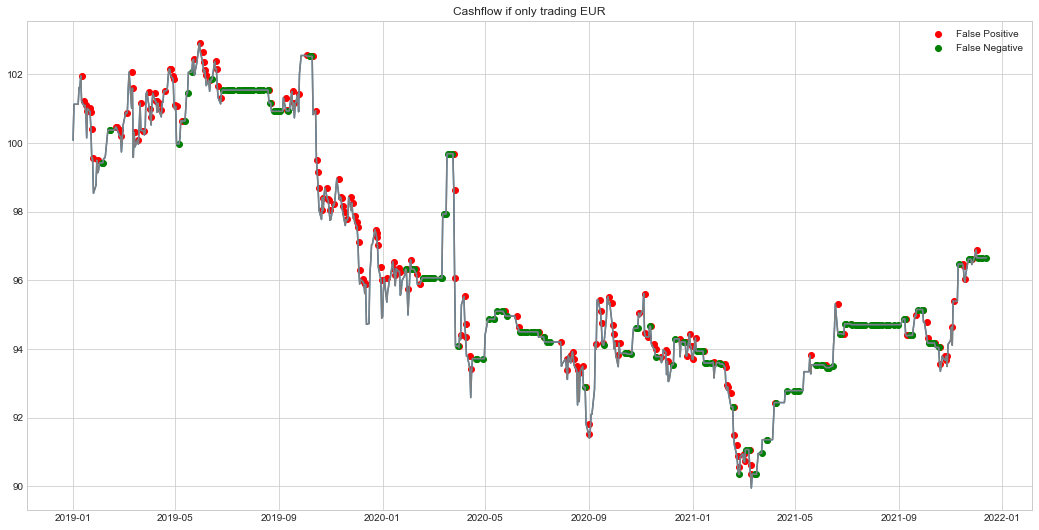

<ipython-input-5-2ce8cda70e39>:77: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fe4c0c0a130>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend([plot_cash, plot_fp, plot_fn, plot_cash], ['Cash', 'False Positive', 'False Negative'])


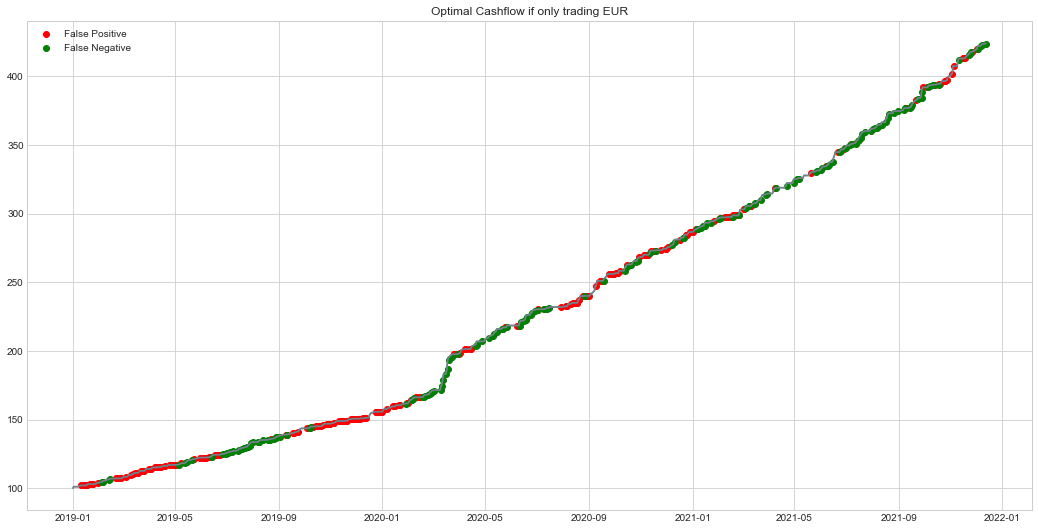

                0
count  770.000000
mean    96.334952
std      3.308067
min     89.949027
25%     93.906365
50%     94.955856
75%     99.684121
max    102.897157


In [12]:
modelGBP = baggingRegression(X_scaled_train, y_train_GBP)
testModel(modelGBP, X_scaled_test, y_test_GBP, "EUR", testData.GBP_Open)

### CAD Training and Testing

OOB: 1.000
RMSE: 0.006
MAE: 0.005
R^2: 0.983


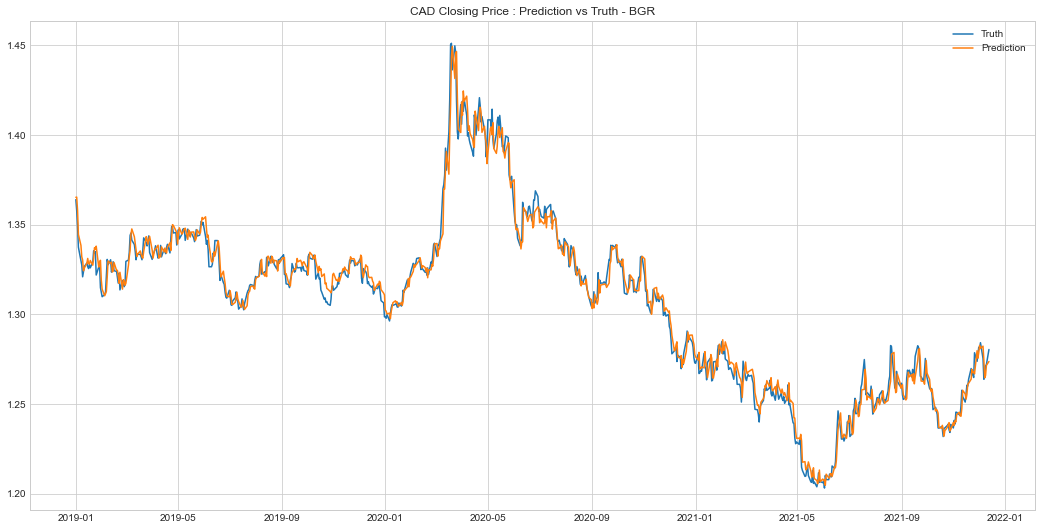

<ipython-input-5-2ce8cda70e39>:67: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fe4d1e4f6d0>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend([plot_cash, plot_fp, plot_fn, plot_cash], ['Cash', 'False Positive', 'False Negative'])


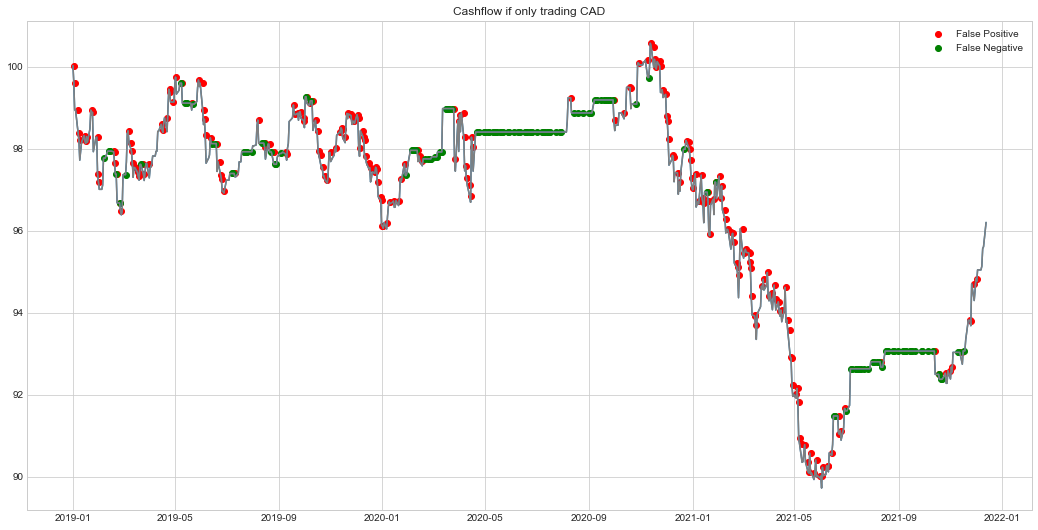

<ipython-input-5-2ce8cda70e39>:77: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fe4a9bb4b50>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend([plot_cash, plot_fp, plot_fn, plot_cash], ['Cash', 'False Positive', 'False Negative'])


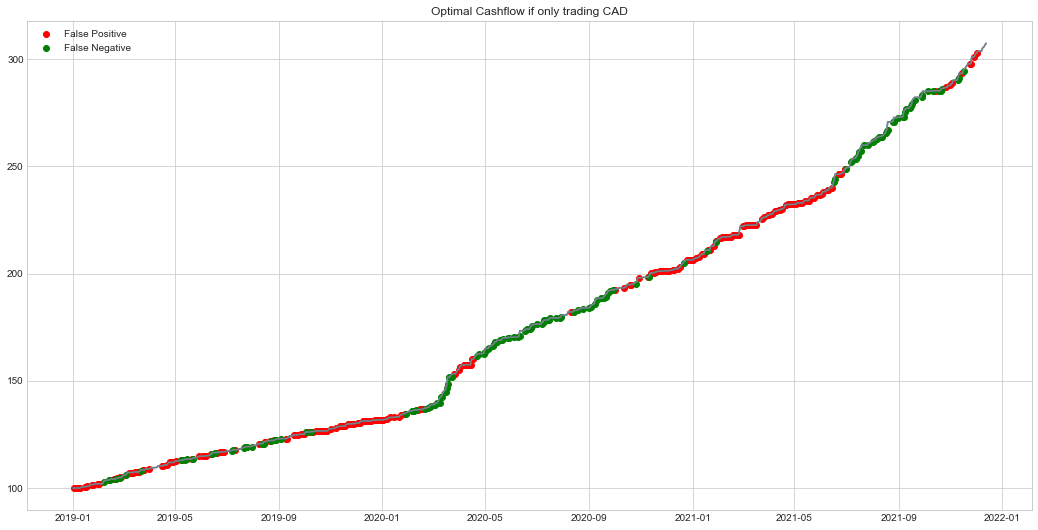

                0
count  770.000000
mean    96.697930
std      2.586709
min     89.718422
25%     94.986646
50%     97.747984
75%     98.400910
max    100.566299


In [13]:
modelCAD = baggingRegression(X_scaled_train, y_train_CAD)
testModel(modelCAD, X_scaled_test, y_test_CAD, "CAD", testData.CAD_Open)

### Simulation

In [14]:
#Formatting and Scaling
predictions_JPY = modelJPY.predict(X_scaled_test)
predictions_EUR = modelEUR.predict(X_scaled_test)
predictions_GBP = modelGBP.predict(X_scaled_test)
predictions_CAD = modelCAD.predict(X_scaled_test)

94.58728939312631


<AxesSubplot:>

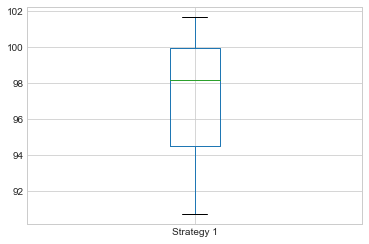

In [15]:
cash = 100
logs1 = []
for i in range(0,len(y_test_JPY)):
    percentChanges = []
    if (predictions_JPY[i] - X_test["JPY_Open"][i]) > 0:
        percentChanges.append(((y_test_JPY[i]-X_test["JPY_Open"][i])/X_test["JPY_Open"][i]))
    if (predictions_EUR[i] - X_test["EUR_Open"][i]) > 0:
        percentChanges.append(((y_test_EUR[i]-X_test["EUR_Open"][i])/X_test["EUR_Open"][i]))
    if (predictions_GBP[i] - X_test["GBP_Open"][i]) > 0:
        percentChanges.append(((y_test_GBP[i]-X_test["GBP_Open"][i])/X_test["GBP_Open"][i]))
    if (predictions_CAD[i] - X_test["CAD_Open"][i]) > 0:
        percentChanges.append(((y_test_CAD[i]-X_test["CAD_Open"][i])/X_test["CAD_Open"][i]))
    if len(percentChanges)>0:
        cashPer = cash/len(percentChanges)
        for percent in percentChanges:
            cash += cashPer*percent
    logs1.append(cash)
print(cash)
pd.DataFrame(logs1, columns=['Strategy 1']).boxplot()

In [16]:
pd.DataFrame(logs1).describe()

,0
count,770.000000
mean,97.301215
std,2.986539
min,90.685989
25%,94.499678
50%,98.151799
75%,99.950208
max,101.680319


### Outcome

Not Great. This strategy would lose you ~6% if implimented.

## Strategy 2
1. Use Bagging Regression to predict the closing prices of YEN, EUR, GBP, and CAD
2. If the predicted close is higher than the open then buy

- If more than 1 is a buy, **buy the best**

97.81694990100861


<AxesSubplot:>

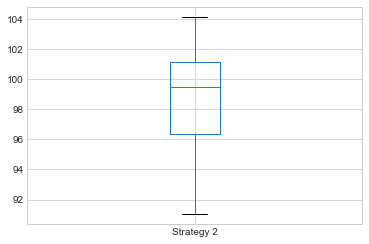

In [17]:
cash = 100
logs2 = []
for i in range(0,len(y_test_JPY)):
    best = 0
    actual = 0
    if (predictions_JPY[i] - X_test["JPY_Open"][i])/X_test["JPY_Open"][i] > best:
        best = (predictions_JPY[i] - X_test["JPY_Open"][i])/X_test["JPY_Open"][i]
        actual = (((y_test_JPY[i]-X_test["JPY_Open"][i])/X_test["JPY_Open"][i]))
    if (predictions_EUR[i] - X_test["EUR_Open"][i])/X_test["EUR_Open"][i] > best:
        best = (predictions_EUR[i] - X_test["EUR_Open"][i])/X_test["EUR_Open"][i]
        actual = (((y_test_EUR[i]-X_test["EUR_Open"][i])/X_test["EUR_Open"][i]))
    if (predictions_GBP[i] - X_test["GBP_Open"][i])/X_test["GBP_Open"][i] > best:
        best = (predictions_GBP[i] - X_test["GBP_Open"][i])/X_test["GBP_Open"][i]
        actual = (((y_test_GBP[i]-X_test["GBP_Open"][i])/X_test["GBP_Open"][i]))
    if (predictions_CAD[i] - X_test["CAD_Open"][i])/X_test["CAD_Open"][i] > best:
        best = (predictions_CAD[i] - X_test["CAD_Open"][i])/X_test["CAD_Open"][i]
        actual = (((y_test_CAD[i]-X_test["CAD_Open"][i])/X_test["CAD_Open"][i]))
    cash += cash*actual
    logs2.append(cash)
print(cash)
pd.DataFrame(logs2, columns=['Strategy 2']).boxplot()

In [18]:
pd.DataFrame(logs2).describe()

,0
count,770.000000
mean,98.574681
std,3.190248
min,91.014238
25%,96.358552
50%,99.496738
75%,101.133507
max,104.149290
